<a href="https://colab.research.google.com/github/shell769324/NILBIE/blob/main/where_mask/MML_Where_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount your Drive and Move required Files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf '/content/drive/My Drive/SSCR_dataset/emnlp20_sscr/data/dataset.tar.gz'

In [89]:
%matplotlib inline
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import h5py
import cv2
from PIL import Image
import numpy as np
import re
import collections
from google.colab.patches import cv2_imshow
import tqdm

In [6]:
#Create directory
def create_path(directory):
  if not os.path.exists(directory):
      os.makedirs(directory)

In [7]:
filename = '/content/GeNeVA_datasets/data/iCLEVR/clevr_train.h5'
img_save_path = '/content/rendered_images/'
txt_save_path = '/content/rendered_text/'
create_path(img_save_path)
create_path(txt_save_path)

In [47]:
def create_grid(x, y, startx, endx, starty, endy):  
  grid = [[0]*x for _ in range(y)]
  for i in range(startx, endx):
    for j in range(starty , endy):
      grid[i][j] = 1
  return grid


In [48]:
#create dictionary of grids
shapex = 128
shapey = 128
grid_dicts = {}
grid0 = create_grid(shapex, shapey, 0,0,0,0)
grid_dicts[0] = grid0 
grid1 = create_grid(shapex, shapey, 0, shapex//2, shapex//2, shapex)
grid_dicts[1] = grid1 
grid2 = create_grid(shapex, shapey, 0, shapex//2, 0, shapex//2)
grid_dicts[2] = grid2
grid3 = create_grid(shapex, shapey, shapex//2, shapex, 0, shapex//2)
grid_dicts[3] = grid3
grid4 = create_grid(shapex, shapey, shapex//2, shapex, shapex//2, shapex)
grid_dicts[4] = grid4

In [50]:
def get_dict(dicts, coords, objects):
  """
  return the coordinate of the newly added object
  """
  o_idx = [i for i, x in enumerate(objects) if x == 1]
  # print(o_idx)
  # print(dicts)
  for idx in o_idx:
    if idx not in dicts:
      dicts[idx] = coords[idx]
      return coords[idx]


In [109]:
def get_quadrant(coords):
  x, y, _ = coords
  if x == 64 and y == 64:
    return 0
  elif x >= 64 and y >= 64:
    return 4
  elif x >= 64 and y <= 64:
    return 1
  elif x <= 64 and y <= 64:
    return 2
  elif x <= 64 and y >= 64:
    return 3 

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text']>
<HDF5 dataset "images": shape (5, 128, 128, 3), type "|u1">
<HDF5 dataset "coords": shape (5, 24, 3), type "<f8">
<HDF5 dataset "objects": shape (5, 24), type "<f8">
[64.         54.93333333 11.10163403]
1 QUAD ["Add a cyan cylinder at the center"


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


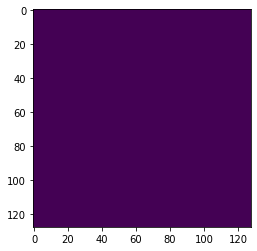

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


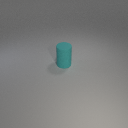

[19.2        50.13333333 11.72945213]
2 QUAD  "Add a green sphere behind it on the left"


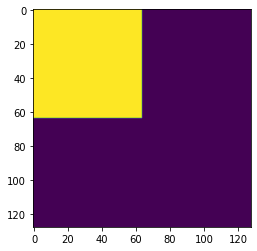

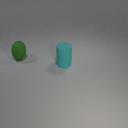

[113.2         57.6         10.76264668]
1 QUAD  "Add a cyan cube in front of it on the right and in front of the cyan cylinder on the right"


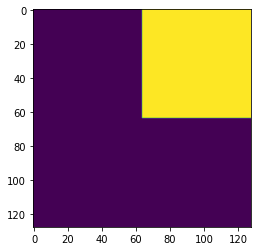

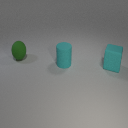

[81.6        75.2         9.02450657]
4 QUAD  "Add a brown sphere in front of it on the left and in front of the cyan cylinder on the right"


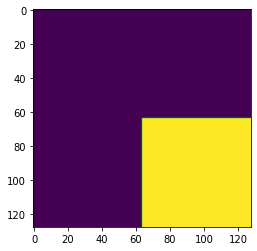

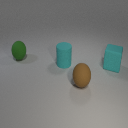

[52.8        41.06666667 13.17800331]
2 QUAD  "Add a cyan sphere behind the green sphere on the right and behind the cyan cylinder on the left"]


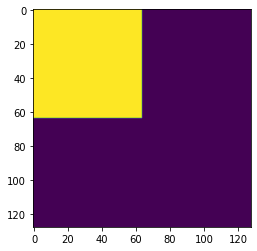

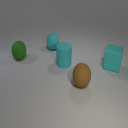

In [74]:
### TO understand the file structure of the h5py file
fnew = h5py.File(filename, 'r')
batch_size_copy = 1
for i in range(batch_size_copy):
  xid = f'{i:06d}'
  txt_values = fnew[xid]['text'].value.split(',')
  print(fnew[xid].keys())
  print(fnew[xid]['images'])
  print(fnew[xid]['coords'])
  print(fnew[xid]['objects'])
  # print(fnew[xid]['coords'].value)
  # print(fnew[xid]['objects'].value)
  img_path = fnew[xid]['images']
  dicts = {}
  where_mask = []
  for i in range(5):
    coord_of_object = get_dict(dicts, fnew[xid]['coords'].value[i], fnew[xid]['objects'].value[i])
    print(coord_of_object)
    quad = get_quadrant(coord_of_object)
    print(quad, 'QUAD', txt_values[i])
    if i >0:
      mask_grid = grid_dicts[quad]
    else:
      mask_grid = grid_dicts[0]
    where_mask.append(mask_grid)
    plt.imshow(mask_grid)
    plt.show()
    cv2_imshow(img_path.value[i])

# NEW DATASET

In [105]:
def get_num_keys(destination_path):
  fcheck = h5py.File(destination_path, 'r')
  print(len(fcheck.keys()))
  return len(fcheck.keys())

In [111]:
destination_path = 'clevr_train_where_mask.h5'
original_path = '/content/GeNeVA_datasets/data/iCLEVR/clevr_train.h5'

fs = h5py.File(original_path, 'r')
fd = h5py.File(destination_path, 'w')

#get number of datasets in h5py file
batch_size_copy = get_num_keys(original_path) -2

for i in range(batch_size_copy):
  xid = f'{i:06d}'
  fs.copy(xid,fd)

fs.copy('background', fd)
fs.copy('entities', fd)
fs.close()
fd.close()

6005
6003


In [98]:
fd = h5py.File(destination_path, 'r')
print(fd.keys())

<KeysViewHDF5 ['background', 'entities']>


In [112]:
destination_path = '/content/destination.h5'
fdest = h5py.File(destination_path, 'r+')
num_keys_in_destination = get_num_keys(destination_path) - 2
count = 0
for i in (range(num_keys_in_destination)):
  count += 1
  print(count ,'/', num_keys_in_destination)
  xid = f'{i:06d}'
  # img_path = fdest[xid]['images']
  dicts = {}
  where_mask = []
  for i in range(5):
    coord_of_object = get_dict(dicts, fdest[xid]['coords'].value[i], fdest[xid]['objects'].value[i])
    # print(coord_of_object)
    quad = get_quadrant(coord_of_object)
    # print(quad, 'QUAD')
    if i > 0:
      mask_grid = grid_dicts[quad]
    else:
      mask_grid = grid_dicts[0]
    where_mask.append(mask_grid)
    # plt.imshow(mask_grid)
    # plt.show()
    # cv2_imshow(img_path.value[i])
  fdest[xid].create_dataset('where', data = np.array(where_mask))

6005
1 / 6003
2 / 6003
3 / 6003
4 / 6003
5 / 6003
6 / 6003
7 / 6003
8 / 6003
9 / 6003
10 / 6003
11 / 6003
12 / 6003
13 / 6003
14 / 6003
15 / 6003
16 / 6003
17 / 6003
18 / 6003
19 / 6003
20 / 6003
21 / 6003
22 / 6003
23 / 6003
24 / 6003

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  del sys.path[0]


Streaming output truncated to the last 5000 lines.
1004 / 6003
1005 / 6003
1006 / 6003
1007 / 6003
1008 / 6003
1009 / 6003
1010 / 6003
1011 / 6003
1012 / 6003
1013 / 6003
1014 / 6003
1015 / 6003
1016 / 6003
1017 / 6003
1018 / 6003
1019 / 6003
1020 / 6003
1021 / 6003
1022 / 6003
1023 / 6003
1024 / 6003
1025 / 6003
1026 / 6003
1027 / 6003
1028 / 6003
1029 / 6003
1030 / 6003
1031 / 6003
1032 / 6003
1033 / 6003
1034 / 6003
1035 / 6003
1036 / 6003
1037 / 6003
1038 / 6003
1039 / 6003
1040 / 6003
1041 / 6003
1042 / 6003
1043 / 6003
1044 / 6003
1045 / 6003
1046 / 6003
1047 / 6003
1048 / 6003
1049 / 6003
1050 / 6003
1051 / 6003
1052 / 6003
1053 / 6003
1054 / 6003
1055 / 6003
1056 / 6003
1057 / 6003
1058 / 6003
1059 / 6003
1060 / 6003
1061 / 6003
1062 / 6003
1063 / 6003
1064 / 6003
1065 / 6003
1066 / 6003
1067 / 6003
1068 / 6003
1069 / 6003
1070 / 6003
1071 / 6003
1072 / 6003
1073 / 6003
1074 / 6003
1075 / 6003
1076 / 6003
1077 / 6003
1078 / 6003
1079 / 6003
1080 / 6003
1081 / 6003
1082 / 6003
1

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


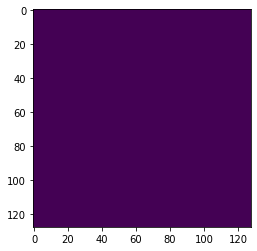

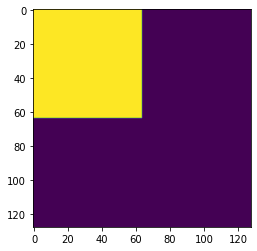

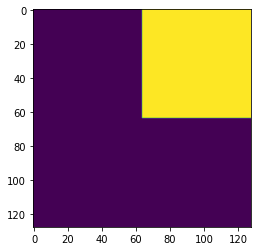

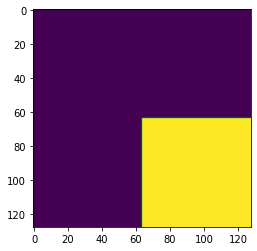

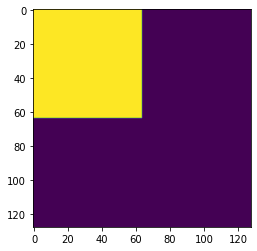

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


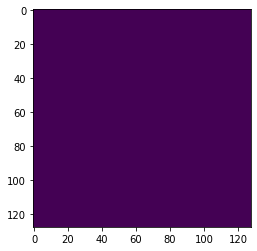

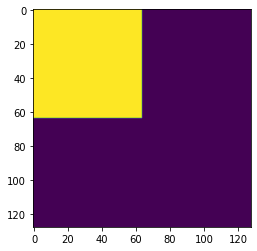

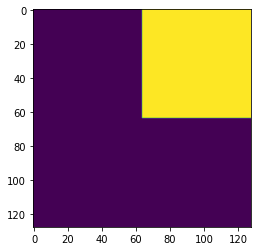

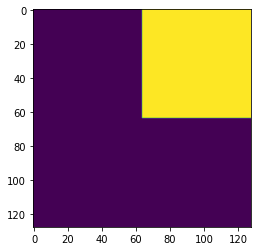

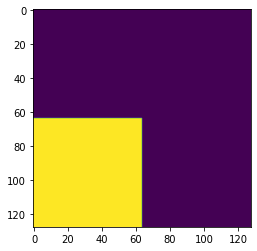

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


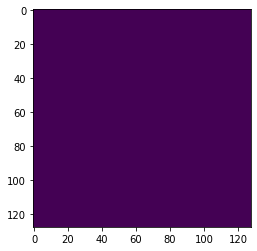

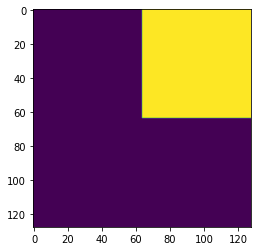

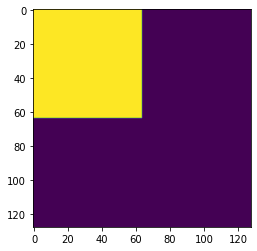

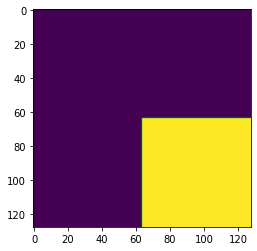

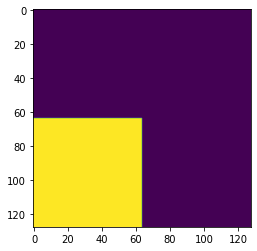

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


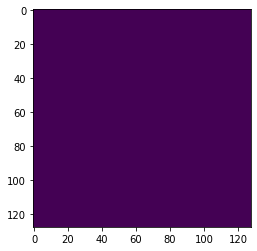

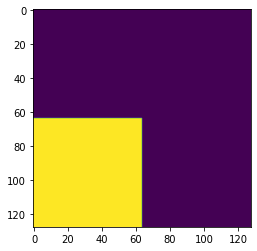

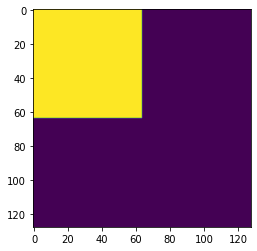

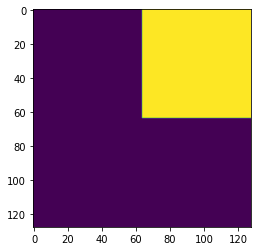

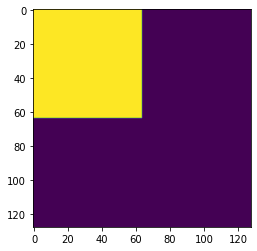

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


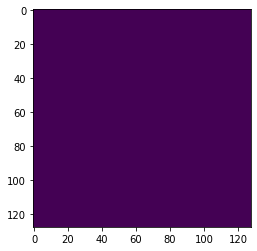

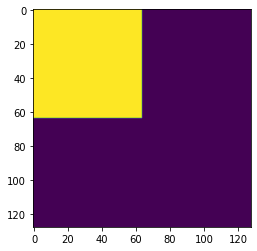

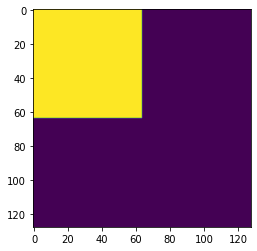

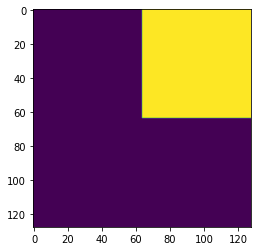

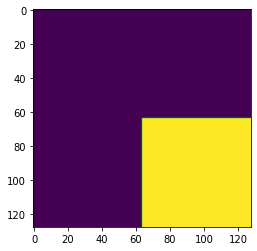

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


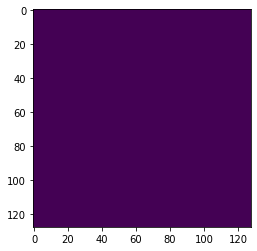

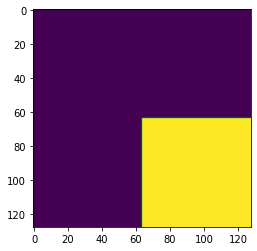

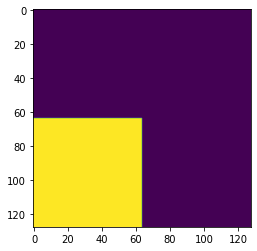

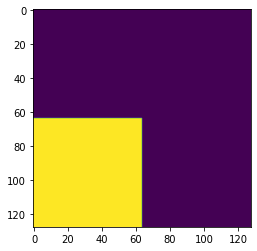

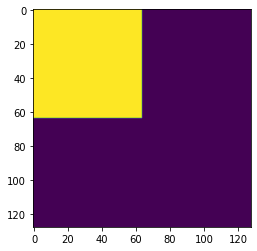

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


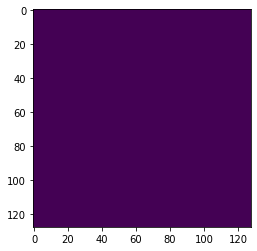

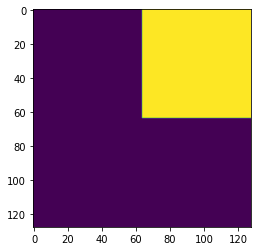

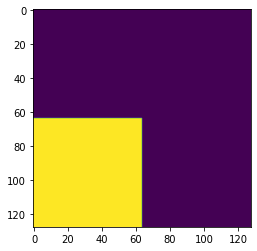

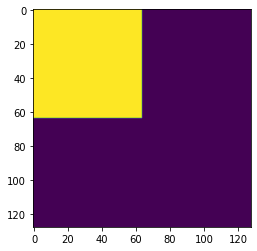

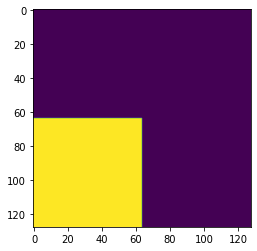

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


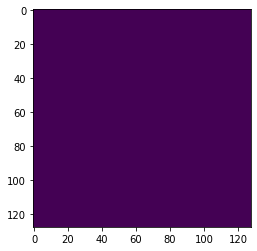

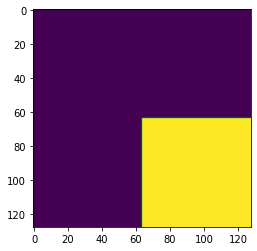

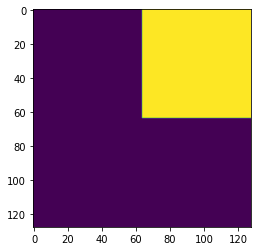

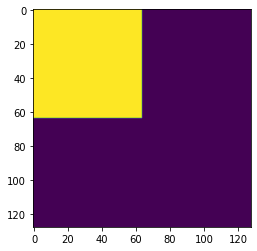

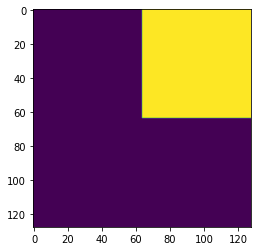

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


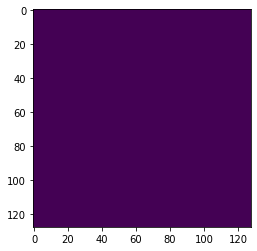

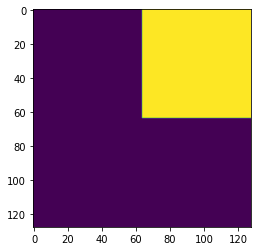

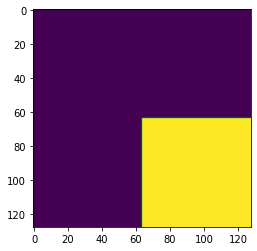

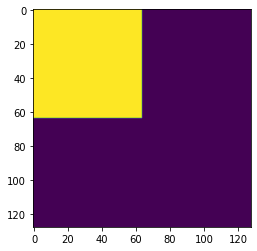

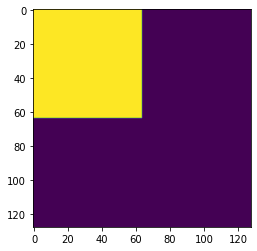

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


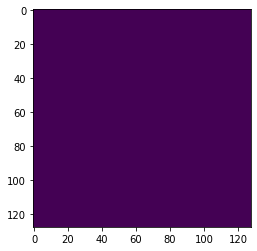

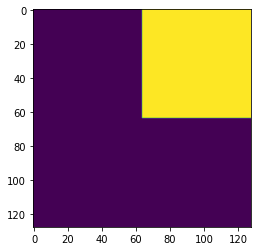

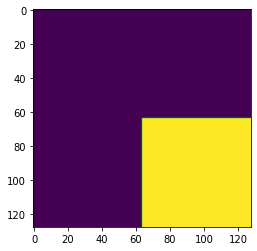

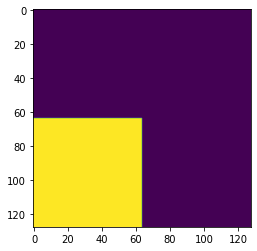

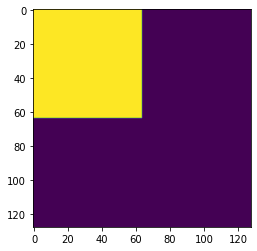

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


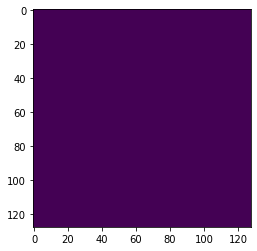

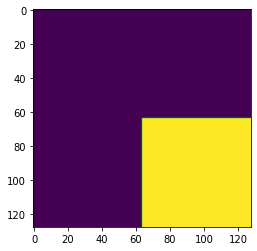

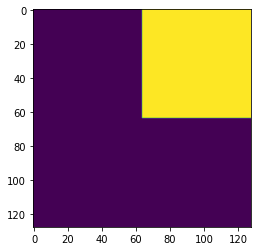

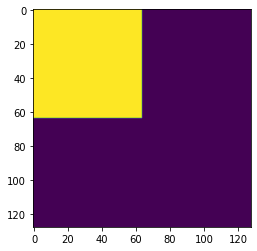

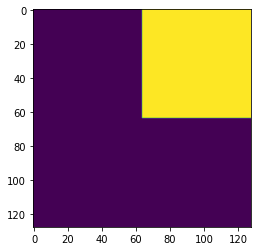

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


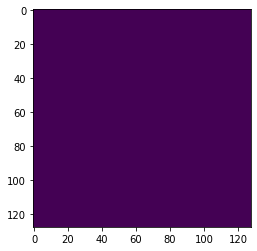

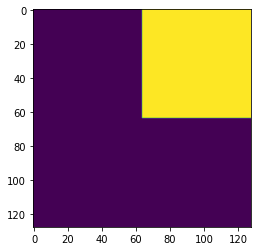

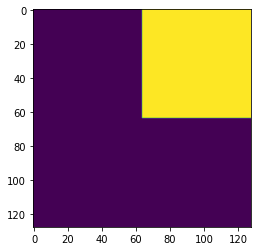

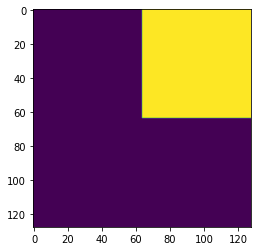

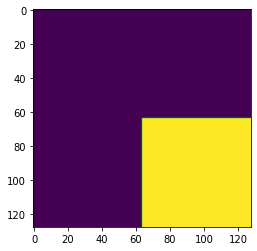

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


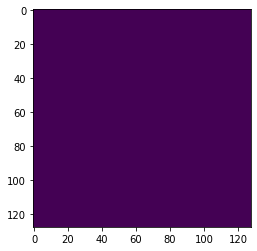

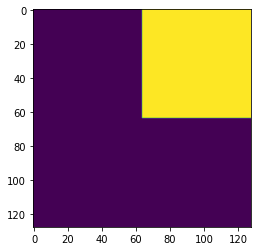

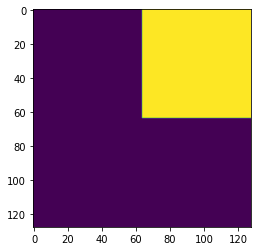

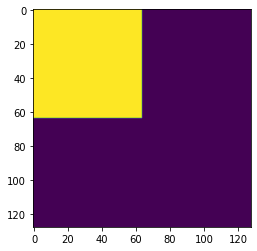

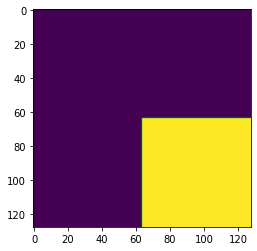

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


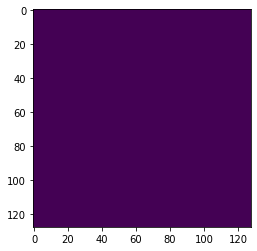

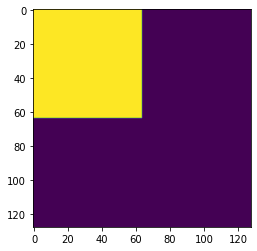

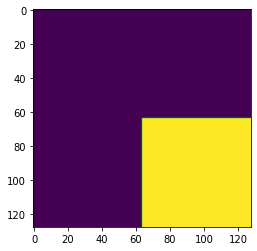

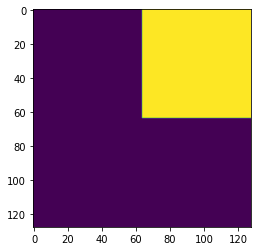

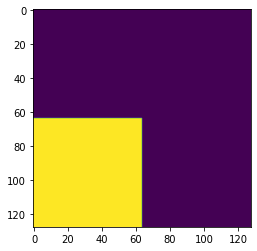

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


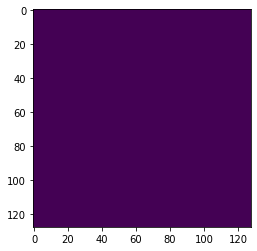

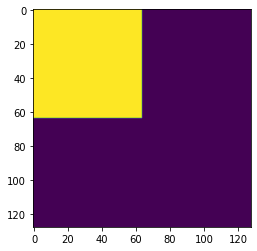

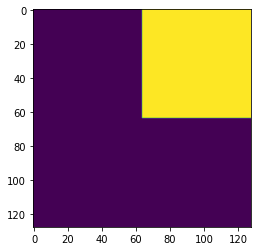

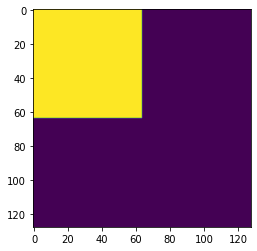

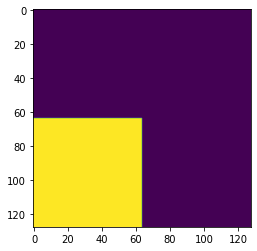

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


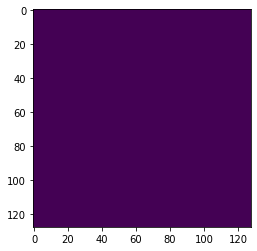

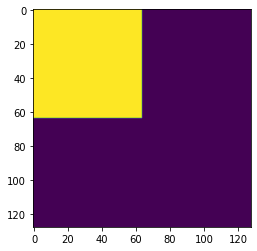

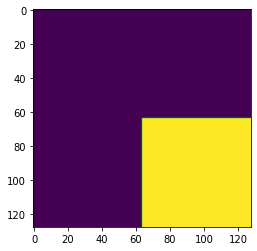

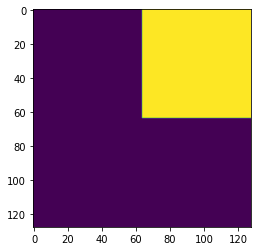

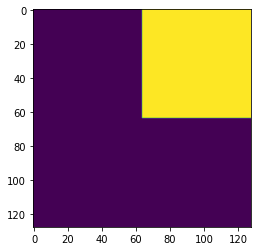

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


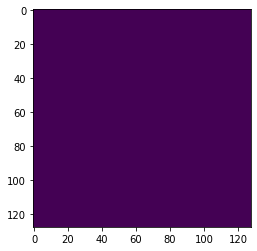

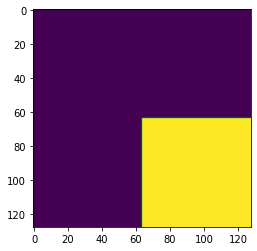

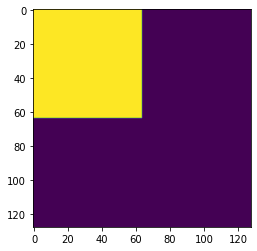

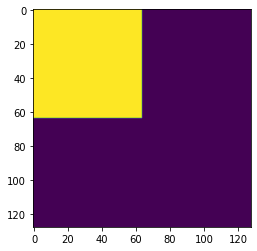

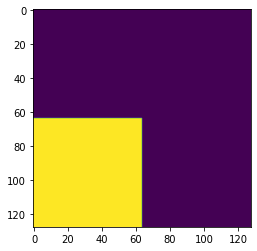

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


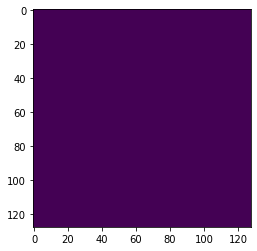

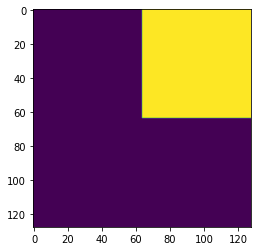

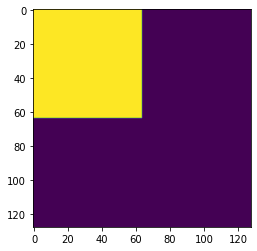

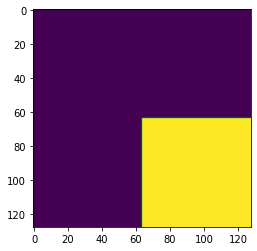

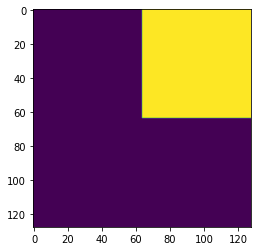

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


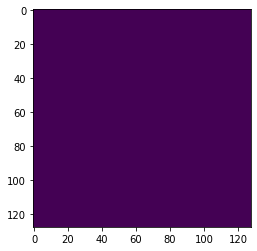

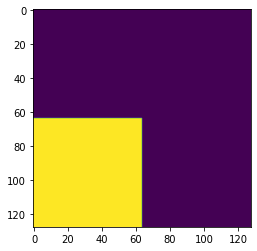

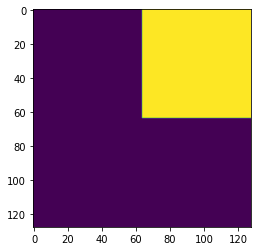

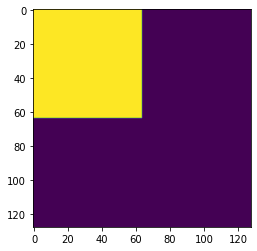

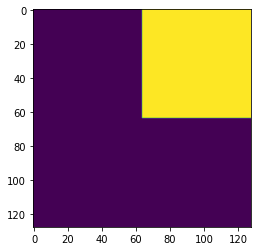

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


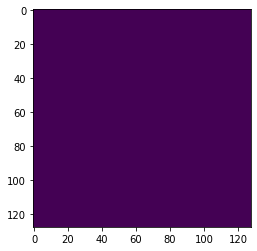

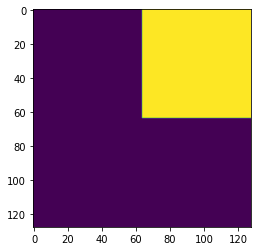

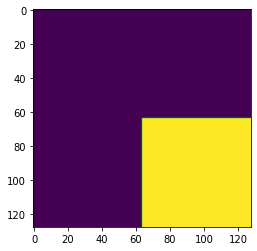

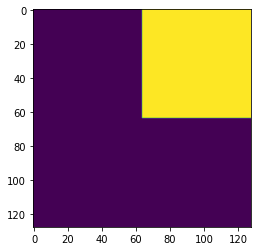

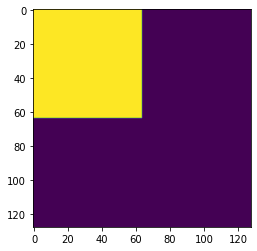

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


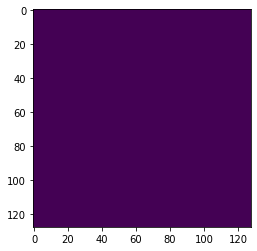

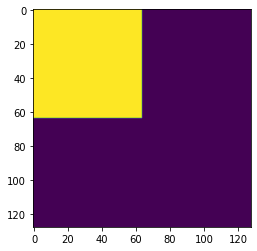

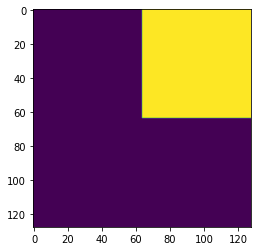

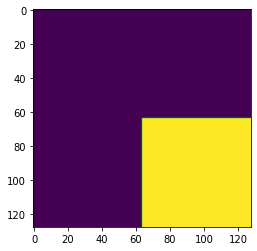

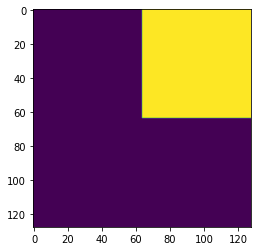

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


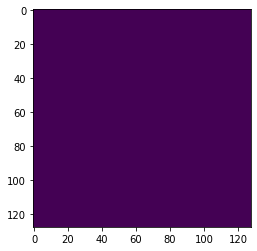

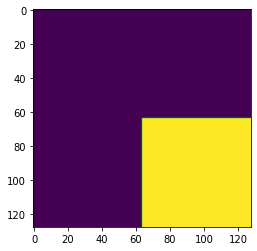

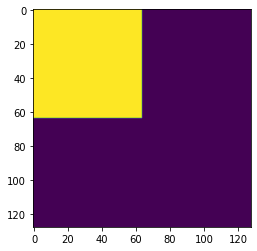

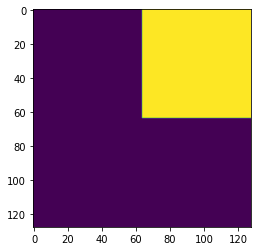

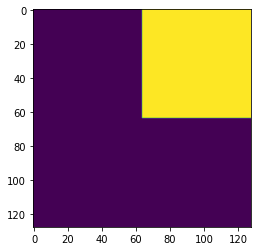

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


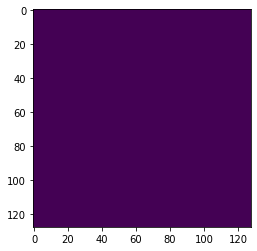

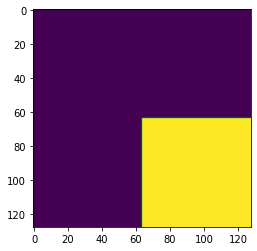

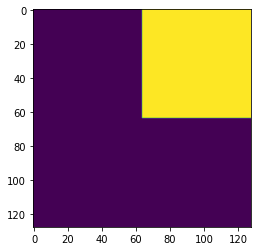

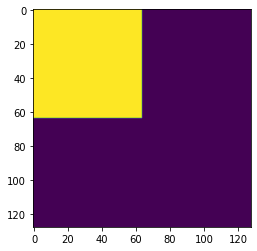

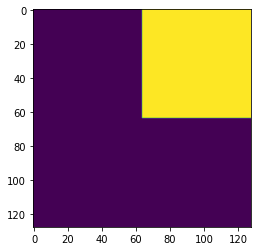

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


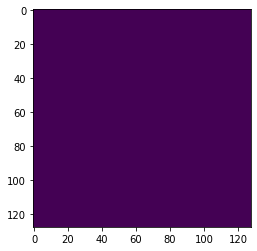

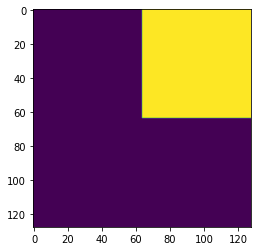

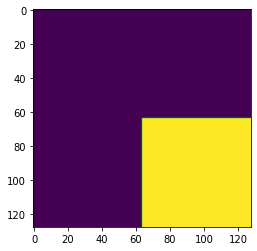

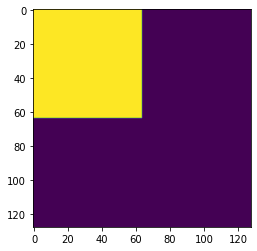

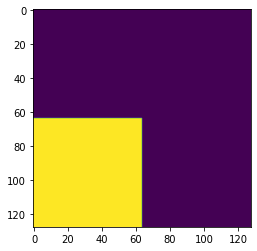

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


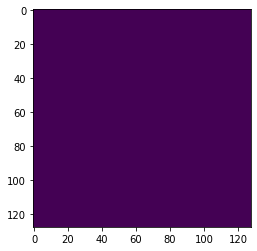

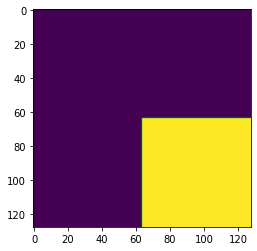

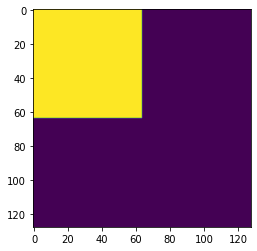

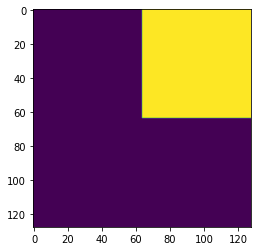

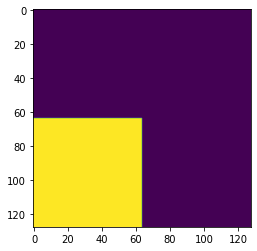

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


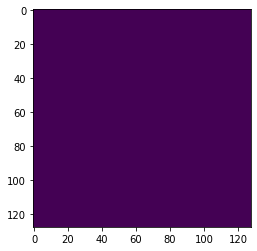

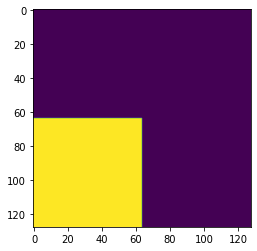

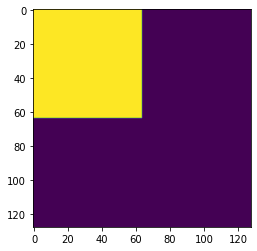

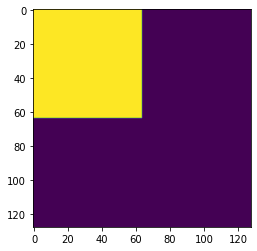

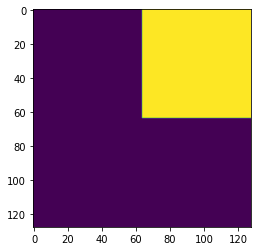

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


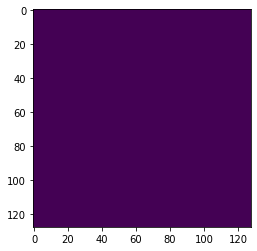

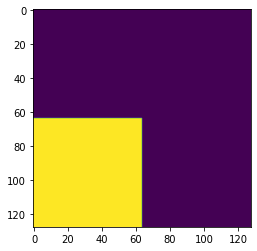

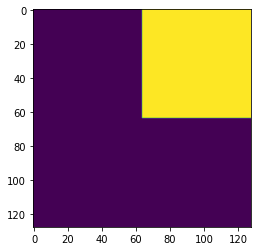

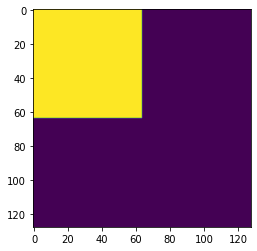

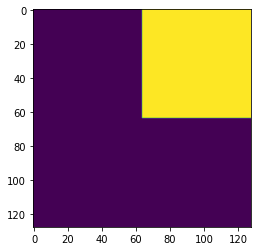

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


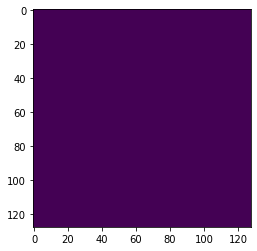

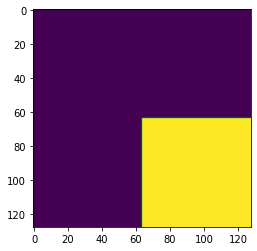

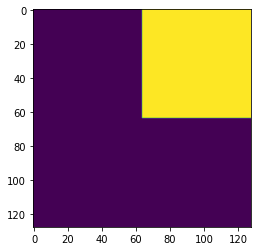

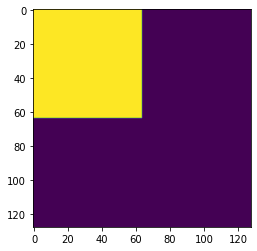

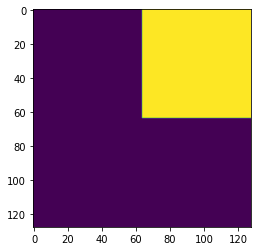

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


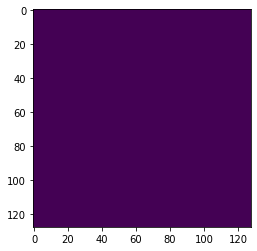

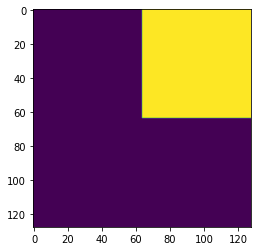

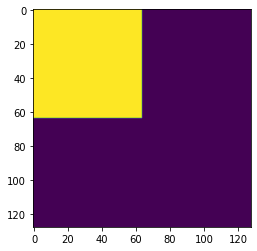

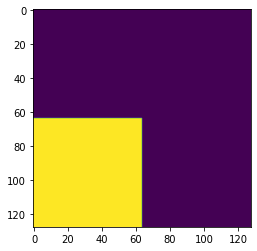

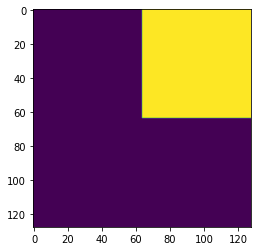

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


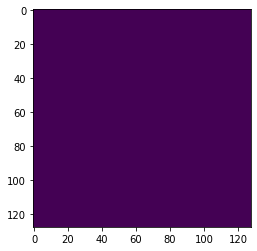

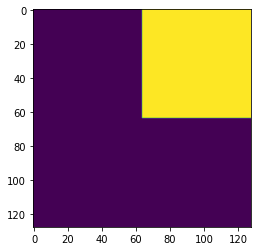

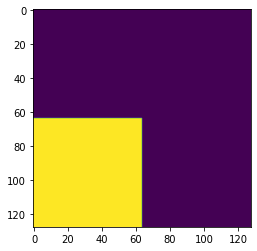

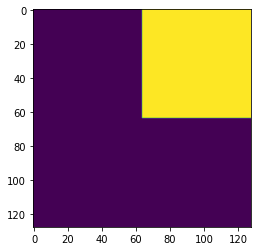

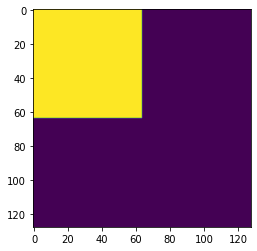

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


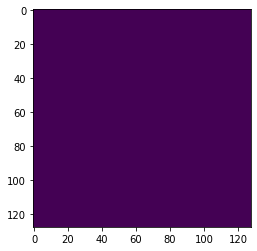

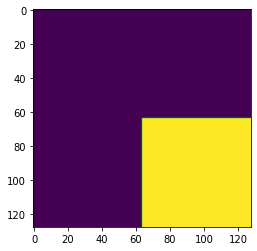

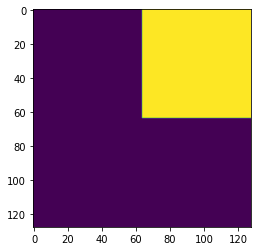

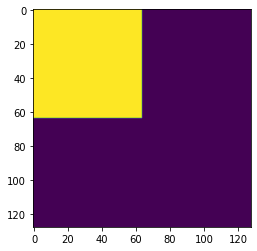

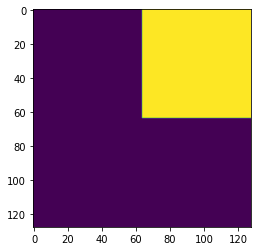

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'where']>
<HDF5 dataset "where": shape (5, 128, 128), type "<i8">


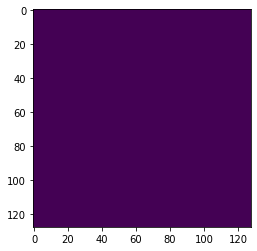

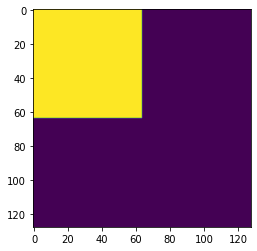

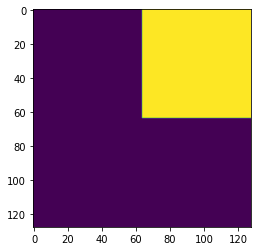

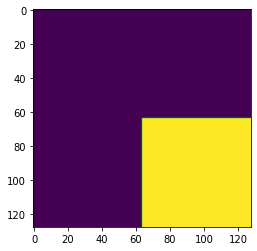

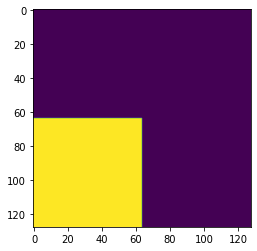

In [113]:
#check the mask where
check_path = '/content/destination.h5'
fcheck = h5py.File(check_path, 'r')
batch_size_copy = 32
for i in range(batch_size_copy):
  xid = f'{i:06d}'
  print(fcheck[xid].keys())
  print(fcheck[xid]['where'])
  for i in range(5):
    mask_grid = fcheck[xid]['where'][i]
    plt.imshow(mask_grid)
    plt.show()
